# How not to find model hyperparameters

In my presentation on visualization, I did something that was very much a bad thing to do in machine learning. I'm curious to know if any of you caught it!

Specifically, this occurred when I showed you how you could use visualizations to help understand what is happening with the performance of a model.

I took the Iris dataset and split it into train and test sets. I wanted to use a kNN classifier to predict Iris species, but I wasn't sure which value of ``k`` would be the best one. 

To find the best value of ``k``, I made many models with many different values of ``k``. I recorded each model's accuracy on the test set, and then visualized them. 

I then found the ``k`` value with the highest accuracy. We could then train a model with that value of ``k`` and use that as our "production" model to predict the species of any new measurements of Iris plants we take in the future.

# The Problem: Part 1

You'll recall from a few lectures back that the major goal in statistical learning is to build a model that **generalizes well**, a model that performs well on data that it is not trained on and has not been overfit or too precisely calibrated to the training data. This is the *exact* reason why we produce a train-test split in the first place. This division is sarcosanct: it *must not* be violated. 

The problem with the approach I took in the visualization lecture is that by choosing the value for the hyperparameter ``k`` on the performance of the model on the test set, I was breaking the wall we must maintain between training and testing data. Choosing ``k`` based on the test data is a way of *indirectly training the model on the test set*. While we are not *directly* training any of the models on the test data, we are allowing the test data to influence a setting of the model, namely, the number of nearest neighbors. This breaks a cardinal rule: the test set should *never* have any influence at all on the model, even when it comes to choosing hyperparameter settings. It should *only* be used in the final stages of your research, as a way to evaluate the model you've made. If you put in tons and tons of work and then get horrible performance on the test data, that's the end of the story: the model probably doesn't work on your data. If you go back and then try to tweak your model so it gets a better score on the test set, it's sort of a form of machine learning "cheating."

What to do then? Just guessing the hyperparameter and seeing what you get on the test set seems like a risky proposition. At the same time, we can't choose a hyperparameter based on performance on the training set, becuase that will likely lead to overfitting on the *training set*. 

# The Solution: Part 1

I'm sure many of you will immediately think up a very intuitive solution to this conundrum. Make *another split*. Specifically:

1. Split your data into training and testing data. Set the testing data aside, don't look at it until you're ready for a final evaluation. 
2. Split your *training* data into two sets. Train on one, evaluate on the other, and tweak your hyperparameters accordingly. 

This is exactly what researchers did to address this problem. Specifically, once you've set aside your test set, you take the remaining data and split it yet again, with one set being called the training set, and the other being called [the validation set](https://en.wikipedia.org/wiki/Test_set#Validation_set). Without even peeking at the test set, you train on the training set and then find the best hyperparameters according to performance on the validation set. We now therefore have 3 sets. Frequently in the statistical learning community researchers go with a 60/20/20 split: 60% training, 20% validatation, and 20% test. 

# The Problem: Part 2

But then the same problem occurs when we do just that. We train on the train set, and evaluate on the validation set, then pick the hyperparameter (like the value for ``k``) based on which value attained the heighest accuracy on the validation set. 

But won't this mean the model will overfit on the *validation* set? Just like earlier we risked overfitting on the test set?

The problem remains. As always, the scientific community has come up with a solution: it's called k-fold cross validation.

# The Solution: Part 2, or  K-Fold Cross Validation

The basic idea behind k-fold cross validation is that you don't just make one validation set, you make many. Here's how it works:

1. Randomly split your data, designating one piece as testing data. Set that aside. 
2. Shuffle the remaining (non-testing) data. 
3. Divide it into k equally-sized sets. Let's say in our case k is 10. We call these equally sized sets **folds**. 
4. Let the first 9 folds be the training set, and the 10th be the validation set. Train on the first 9 folds and get an evaluation metric like accuracy on the 10th. 
5. Then, let the 9th fold be the validation set. Train on folds 1-8 and 10, evaluate on the 9th. 
6. Then, let the 8th fold be the validation set. Train on sets 1-7 and 9-10, evaluate on the 8th. 
7. And so on, until you run out of folds. 
8. When your done, you have 10 accuracy values, one for each fold. Calculate the average of those accuracies and you have an idea of how your model performs on 10 different validation sets. 

Here is a visualization of the 10-fold cross validation that will hopefully make things clearer:

<img src="http://ella.ils.indiana.edu/~vmalic/z639/10_fold_cv.png">

How does this work? Well, we're worried that if we had one validation set, we might overfit to the validation set. By random chance, given how the validation set was split off, we might find a hyperparameter value that works *well for that one validation set* but does not generalize well.

But by performing k-fold cross validation, we get multiple accuracies. It might accidentally work well for one of the validation sets, but that gets averaged out when we consider the accuracy for the other k-1 datasets. 

# Choosing K (as in fold, not NN)

How do you choose how many folds you should have? As always, this depends on the data. If you choose 1000-fold CV, then each of the validation sets will only have a small amount of data, so the accuracies may vary wildly. If you choose 2-fold CV, there is a lot of data in the validation set, but you only get two accuracies out of it. You should mostly consider how many samples you have. If you have a million samples, a 1000-fold CV is possible, since each validation set would have 1000 samples in it - but then you'd have to take into account how long it would take to train 1000 models. When it comes to what you see most often in the literature, 10-fold CV seems to be quite common. 

# Doing this in Scikit-Learn

Doing k-fold cross validation from scratch is a very tedious task, with many steps. Once again, scikit-learn saves the day and gives us a simple method that basically does it all for us. 

Let's get the Iris data and train a k-NN classifier on it. *For now*, I'll use ``k=5``. 

First, we split the data into train and test. I'll make the test size .33, since there are 150 samples. That will give us a testing set size of 50. 

In [1]:
import numpy as np

np.random.seed(3057)

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234)
print(X_train.shape)
print(X_test.shape)

(100, 4)
(50, 4)


Next, we initialize our Nearest Neighbor classifier.

In [2]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5)

Now, we import a method from sklearn called ``cross_val_score`` that will do all the cross validation steps for us. 

In [3]:
from sklearn.model_selection import cross_val_score

There are 5 parameters we must pass to the method ``cross_val_score``. 

1. The untrained model. In our case, this is the variable ``clf``.
2. The training data, ``X_train``. ``cross_val_score`` will generate the validation sets automatically.
3. The training labels, ``y_train``. 
4. A parameter called ``scoring`` which takes a string as its value. This indicates *what kind of metric* you want to use. The string `accuracy` uses accuracy. The string ``r2`` will calculate R-squared for regression problems. A full list of strings for metrics you can use can be [found here](http://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values). 
5. A parameter called ``cv`` indicating the number of folds. 

``cross_val_score`` returns a list that is the same length as the parameter ``cv``. It lists the evaluation metric obtained for each fold.

I'm going to use ``cross_val_score`` to run 10-fold cross validation on the training data. I'm going to use accuracy as teh scoring metric (but I could use F1 scores or recall or whatever if I wanted).

In [4]:
cv_scores = cross_val_score(clf, X_train, y_train, scoring="accuracy", cv=10)
print(cv_scores)

[ 1.          1.          1.          0.8         0.88888889  0.88888889
  1.          0.88888889  1.          1.        ]


As you can see, for the 1st, 2nd, and 3rd folds our 5NN classifier got 100% accuracy on the held-out validation set. It got 80% on the 4th, 89% on the 5th, and so on. 80% is pretty bad compared to the others: imagine if we had only one validation set and by complete chance it was this same one that got us an 80% accuracy. We'd conclude ``k=5`` is bad, without knowing that ``k=5`` would have 100% accuracy on a completely different validation set. This is why we make many validation sets.

By averaging these accuracies we can get a composite score that gives us an idea how well our classifier did over all folds:

In [5]:
print(np.mean(cv_scores))

0.946666666667


95%: some did well, some didn't do as well. But overall, we got a pretty high score for ``k=5``. 

# Using CV for Hyperparameter Optimization

Let's go back to the original problem: how do we find the optimal value for ``k``?

What we do is we first select a set of candidate values for ``k``. Like in the visualization demonstration, I'm going to use every odd number from 1 to 50. 

In [6]:
k_candidates = np.arange(1, 50, 2)

For *each hyperparameter candidate*, run k-fold cross validation. Get and save the average accuracy attained during each CV. I'll do 10 fold for this example. 

Then, see which hyperparameter had the highest average accuracy. **That's** your optimal value for k. 

Finally, using only that value of ``k``, evaluate on the held-out test data. This is the final accuracy you report to your boss or in your research paper. 

Let's do it in scikit-learn:

In [7]:
average_accuracies = []

for k in k_candidates:
    clf = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(clf, X_train, y_train, scoring="accuracy", cv=10)
    average_accuracy = np.mean(cv_scores)
    average_accuracies.append(average_accuracy)

Let's explore the average accuracies for value of k using visualization.

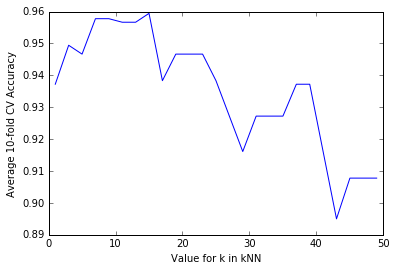

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.ioff()

plt.plot(k_candidates, average_accuracies)
plt.xlabel("Value for k in kNN")
plt.ylabel("Average 10-fold CV Accuracy")
plt.show()

We see that the optimal performance is between 5 and 20, but the best value we achieved was at ``k=15``, with an accuracy of 96%.

Now, let's train our final classifier on all the training data with ``k=15`` and see how well it performs on the held-out test data, for the first - and only- time. 

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix

clf = KNeighborsClassifier(n_neighbors=15)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Final Test Set Accuracy:")
print(accuracy_score(y_test, y_pred))

Final Test Set Accuracy:
0.98


98% accuracy! Our 15-NN model generalized quite well, and since we used cross-validation to find the best value of k, we can be absolutely certain that the test data is truly unseen data. Here's the confusion matrix:

In [10]:
confusion_matrix(y_test, y_pred)

array([[17,  0,  0],
       [ 0, 16,  1],
       [ 0,  0, 16]])

Of the 50 training examples, every one was classified correctly, except for one instance of *I. versicolor* that was erroneously classified as *I. virginica*. Not bad, for data the model has never seen. 

# Not just KNN

Here, I used k-NN as an example, with the hyperparameter ``k`` that needs to be optimized. But you can use this cross validation to optimize *any* model that uses hyperparameters. For example, there's the extremely important hyperparameter in SVM called ``C``. Generate some candidates for ``C`` and find k-fold CV accuracies for each value. Choose a value for ``C`` that gets the highest accuracy.

Recall that SVM also had a non-numeric hyperparameter: the type of kernel you can use, linear, rbf, or poly. The same principle applies here. Do k-fold CV for each of the kernels, and find the one that has the best average accuracy.